In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
from datetime import datetime
from utils import setup_seed
import matplotlib.pyplot as plt
from tqdm import tqdm
from config import OptimizerConfig, OptimizerType, TrainConfig
import orjson

plt.style.use("ggplot")
plt.rcParams["font.sans-serif"] = ["Maple Mono NF CN"]

In [14]:
# -------------------------
# 1. Simple CNN Model
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, feat_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # 32x32
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # 1x1
        )
        self.fc_feat = nn.Linear(128, feat_dim)
        self.fc_out = nn.Linear(feat_dim, num_classes)

    def forward(self, x, return_feat=False):
        h = self.conv(x).view(x.size(0), -1)
        z = self.fc_feat(h)
        z = F.relu(z)
        out = self.fc_out(z)
        if return_feat:
            return out, z
        return out


In [15]:
# -------------------------
# 2. PACR Loss (batch-wise)
# -------------------------
def pacr_loss(features, labels):
    """
    features: (B, D)
    labels:   (B,)
    """
    loss = 0.0
    num_classes = labels.max().item() + 1
    eps = 1e-8

    for c in range(num_classes):
        idx = labels == c
        if idx.sum() < 2:
            continue
        z = features[idx]  # (Nc, D)
        mean = z.mean(dim=0, keepdim=True)
        loss += ((z - mean) ** 2).sum(dim=1).mean()

    return loss / (num_classes + eps)


In [16]:
# -------------------------
# 3. Training / Evaluation
# -------------------------
def train_epoch(
    epoch, config: TrainConfig, model, loader, optimizer, device, lambda_pacr=0.0
):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, feats = model(x, return_feat=True)
        loss_ce = F.cross_entropy(logits, y)

        loss = loss_ce
        if lambda_pacr > 0:
            # if epoch >= int(config.epochs * 0.6):
            loss_pacr = pacr_loss(feats, y)
            loss = loss + lambda_pacr * loss_pacr

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total


In [17]:
@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_correct, total = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_correct / total


In [18]:
# -------------------------
# 4. Main Experiment
# -------------------------
def main(config: TrainConfig, lambda_pacr=0.0):
    setup_seed(config.seed, deterministic=config.deterministic)
    info = {"train_acc": [], "test_acc": []}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
    transform_test = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    # train_sub_set = torch.utils.data.Subset(train_set, range(0, 10000))
    test_set = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=256)

    model = SimpleCNN().to(device)
    optimizer = config.optimizer.get_optimizer(model.parameters())

    for epoch in tqdm(range(1, config.epochs + 1)):
        train_loss, train_acc = train_epoch(
            epoch, config, model, train_loader, optimizer, device, lambda_pacr
        )
        test_acc = eval_epoch(model, test_loader, device)
        info["train_acc"].append(train_acc)
        info["test_acc"].append(test_acc)
        # print(
        #     f"Epoch {epoch:03d} | "
        #     f"Loss {train_loss:.4f} | "
        #     f"Train Acc {train_acc:.3f} | "
        #     f"Test Acc {test_acc:.3f}"
        # )
    return info


In [19]:
config_a = TrainConfig(
    exp_name="SimpleCNN_PACR_Study",
    epochs=50,
    seed=4,
    deterministic=True,
    batch_size=1280,
    optimizer=OptimizerConfig(
        optimizer_type=OptimizerType.ADAM,
        lr=0.0064,
        weight_decay=8e-05,
    ),
)
lambda_pacr = 0.001
ainfo = main(config_a, lambda_pacr=lambda_pacr)
config_o = TrainConfig(
    exp_name="SimpleCNN_PACR_Study",
    epochs=50,
    seed=4,
    deterministic=True,
    batch_size=1280,
    optimizer=OptimizerConfig(
        optimizer_type=OptimizerType.ADAM,
        lr=0.0064,
        weight_decay=8e-05,
    ),
)
oinfo = main(config_o, lambda_pacr=0.0)

/home/ling/ws/pyWS/pacr/.venv/lib64/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
100%|██████████| 50/50 [07:20<00:00,  8.80s/it]


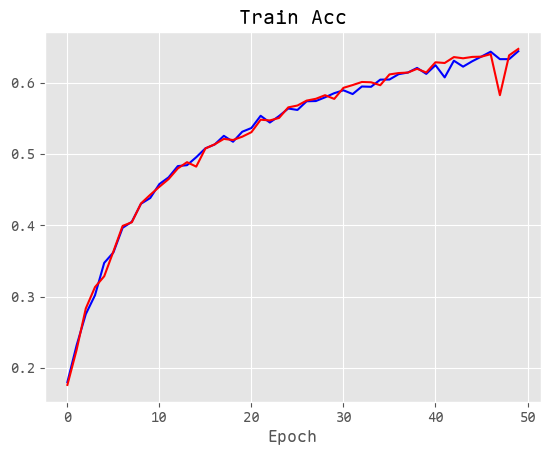

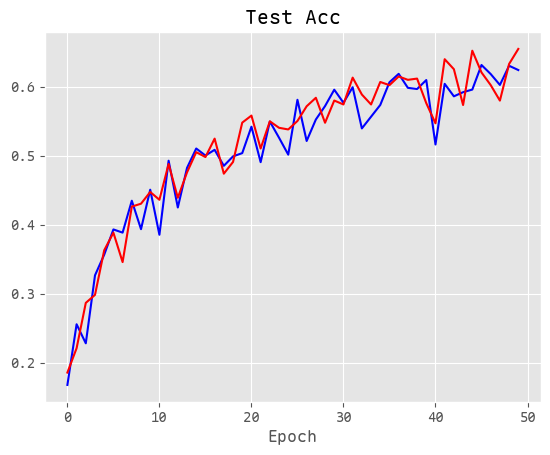

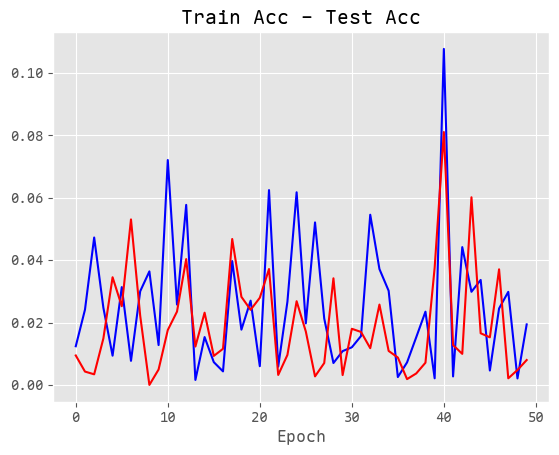

In [20]:
fig, ax = plt.subplots()
ax.plot(oinfo["train_acc"], "b")
ax.plot(ainfo["train_acc"], "r")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(oinfo["test_acc"], "b")
ax.plot(ainfo["test_acc"], "r")
ax.set_xlabel("Epoch")
ax.set_title("Test Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(np.abs(np.array(oinfo["train_acc"]) - np.array(oinfo["test_acc"])), "b")
ax.plot(np.abs(np.array(ainfo["train_acc"]) - np.array(ainfo["test_acc"])), "r")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc - Test Acc")
plt.show()


In [21]:
oinfo["test_acc"][-1], ainfo["test_acc"][-1]

(0.6245, 0.6551)

In [22]:
np.array(oinfo["test_acc"]).mean(), np.array(ainfo["test_acc"]).mean()


(np.float64(0.5103), np.float64(0.518434))

In [23]:
np.array(oinfo["test_acc"]).std(), np.array(ainfo["test_acc"]).std()


(np.float64(0.10703092076591698), np.float64(0.10910769653878684))

In [24]:
timestamp = config_a.timestamp.strftime("%Y%m%d_%H%M%S")
save_dir = Path("results") / timestamp
save_dir.mkdir(parents=True, exist_ok=True)
file_path = save_dir / "ana.json"
# config.save_pretrained(save_dir)
with open(file_path, "wb") as f:
    f.write(
        orjson.dumps(
            {
                "lambda_pacr": lambda_pacr,
                "config_a": config_a,
                "config_o": config_o,
                "ainfo": ainfo,
                "oinfo": oinfo,
            },
            option=orjson.OPT_INDENT_2,
        )
    )
